In [99]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [90]:
companies = [
    "SAP", "IBM", "WDAY", "ADP", "ACN",  # Technology
    "NXPI", "STM", "ADI", "ON", "MCHP", "LSCC", "COHR", "AEIS", "ENTG",  # Semiconductors & Software
    "BX", "KKR", "STT", "AMP", "PNC", "CFG", "BK", "NTRS", "FITB",  # Financials
    "UL", "PDD", "JD", "BABA", "SBUX", "YUM", "ROST", "M", "KSS",  # Consumer Discretionary & Retail
    "ZTS", "DHR", "BDX", "SYK", "BSX", "STE", "MTD", "BIO",  # Healthcare
    "TAP", "KMB", "GIS", "HRL", "MDLZ", "LW", "MNST",  # Consumer Staples
]


In [392]:
companies = ['DJT']

In [393]:
data = pd.DataFrame()

In [394]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [395]:
def scale_data(uncscaled_data):
       price_columns = ['Open', 'High', 'Low', 'Close']
       technical_indicators = ['SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']
       volume_column = 'Volume'
       
       for col in price_columns:
              uncscaled_data = remove_outliers(uncscaled_data, col)
       
       min_max_scaler = MinMaxScaler()
       standard_scaler = StandardScaler()
       standard_scaler_close = StandardScaler()

       price_columns.pop()

       uncscaled_data[price_columns] = standard_scaler.fit_transform(uncscaled_data[price_columns])

       uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])  
       uncscaled_data[[volume_column]] = standard_scaler.fit_transform(uncscaled_data[[volume_column]])

       uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

       return uncscaled_data



In [396]:
def calculate_tech_ind(curr, data):

    data['SMA15'] = ta.sma(curr['Close'], length=15)  # Simple Moving Average
    data['EMA5'] = ta.ema(curr['Close'], length=5)    # Exponential Moving Average
    data['RSI15'] = ta.rsi(curr['Close'], length=15)  # Relative Strength Index

    # Bollinger Bands: Measures volatility with a moving average and standard deviations
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=56, std=2).iloc[:, [0, 2]].T.values

    # MACD and Signal Line: Trend-following momentum indicator
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values

    # On-Balance Volume: Volume-based trend indicator
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])

    # ADX (Average Directional Index): Measures trend strength
    data['ADX'] = ta.adx(curr['High'], curr['Low'], curr['Close']).iloc[:, 0]

    # Aroon Oscillator: Identifies trend direction and strength
    data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(curr['High'], curr['Low']).iloc[:, [0, 1]].T.values
    
    uncleaned_data = pd.concat([curr, data], axis = 0)

    uncleaned_data = uncleaned_data.iloc[14:, :]

    uncleaned_data.fillna(method='ffill', inplace=True)

    uncleaned_data.fillna(method='bfill', inplace=True)

    scaled_data = scale_data(uncleaned_data)

    #result_df = final_pcas(scaled_data)

    return scaled_data

In [397]:
for i in companies:
    try:

        #curr = yf.download(i, start='2014-10-15', end='2024-10-26')
        curr = yf.download(i, period="max")
        curr = curr.reset_index()

        curr.columns = [col[0] for col in curr.columns]

        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()
        result_df = calculate_tech_ind(curr, empty_data)
        data = pd.concat([data, result_df], ignore_index=True)

    except Exception as e:
        print(e, i)

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_31968\2595796236.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


In [398]:
scaled_data = data

In [399]:
def final_pcas(data):
    feature_columns = ['Open', 'High', 'Low', 'SMA15', 'EMA5',
            'RSI15', 'BB_upper', 'BB_lower', 'OBV', 'ADX',
            'Aroon_Up', 'Aroon_Down']

    X = data[feature_columns]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=8)  
    X_pca = pca.fit_transform(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)


    n_components_to_keep = np.argmax(cumulative_variance >= 0.90) 
    pca_final = PCA(n_components=n_components_to_keep)
    X_final = pca_final.fit_transform(X_scaled)

    pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
    pca_df = pd.DataFrame(data=X_final, columns=pca_columns)
    data = pd.DataFrame(data=data, columns=['MACD', 'MACD_signal', 'Close'])
    result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

    return result_df


In [400]:
target = scaled_data[['Close']]  # Ensures 2D shape
standard_scaler_close = StandardScaler()
target_scaled = standard_scaler_close.fit_transform(target)

In [401]:
target_scaled

array([[1.73337069],
       [2.24009981],
       [2.23319572],
       ...,
       [0.50175725],
       [0.50175725],
       [0.50175725]])

In [402]:

input = scaled_data.drop(columns=['Low', 'Open','SMA15', 'BB_lower', 'BB_upper', 'Adj Close', 'Close', 'OBV'])

In [403]:
#input['H-L'] = input['High'] - input['Low']

In [404]:
from joblib import load

loaded_model = load('model_reg.joblib')

In [405]:
target

,Close
0,39.480000
1,43.150002
2,43.099998
3,42.740002
4,41.389999
...,...
1341,30.559999
1342,30.559999
1343,30.559999
1344,30.559999


In [406]:
target_scaled

array([[1.73337069],
       [2.24009981],
       [2.23319572],
       ...,
       [0.50175725],
       [0.50175725],
       [0.50175725]])

In [407]:
y_pred = loaded_model.predict(input)

# Evaluate the model performance
mse = mean_squared_error(target_scaled, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Optional: Calculate R-squared
r2 = loaded_model.score(input, target_scaled)
print(f'R-squared: {r2}')

print('\n ', y_pred, '\n', target_scaled)

Mean Squared Error: 0.03402988351670905
Root Mean Squared Error (RMSE): 0.18447190441015415
R-squared: 0.965970116483291

  [1.9265091 1.9265091 1.9265091 ... 0.6017519 0.6017519 0.6017519] 
 [[1.73337069]
 [2.24009981]
 [2.23319572]
 ...
 [0.50175725]
 [0.50175725]
 [0.50175725]]


In [408]:
len(y_pred)

1346

Mean Squared Error: 0.03402988351670905
Root Mean Squared Error (RMSE): 0.18447190441015415
Mean Squared Error: 1.7850129628989244
Root Mean Squared Error (RMSE): 1.3360437728229282
R-squared: 0.965970116483291


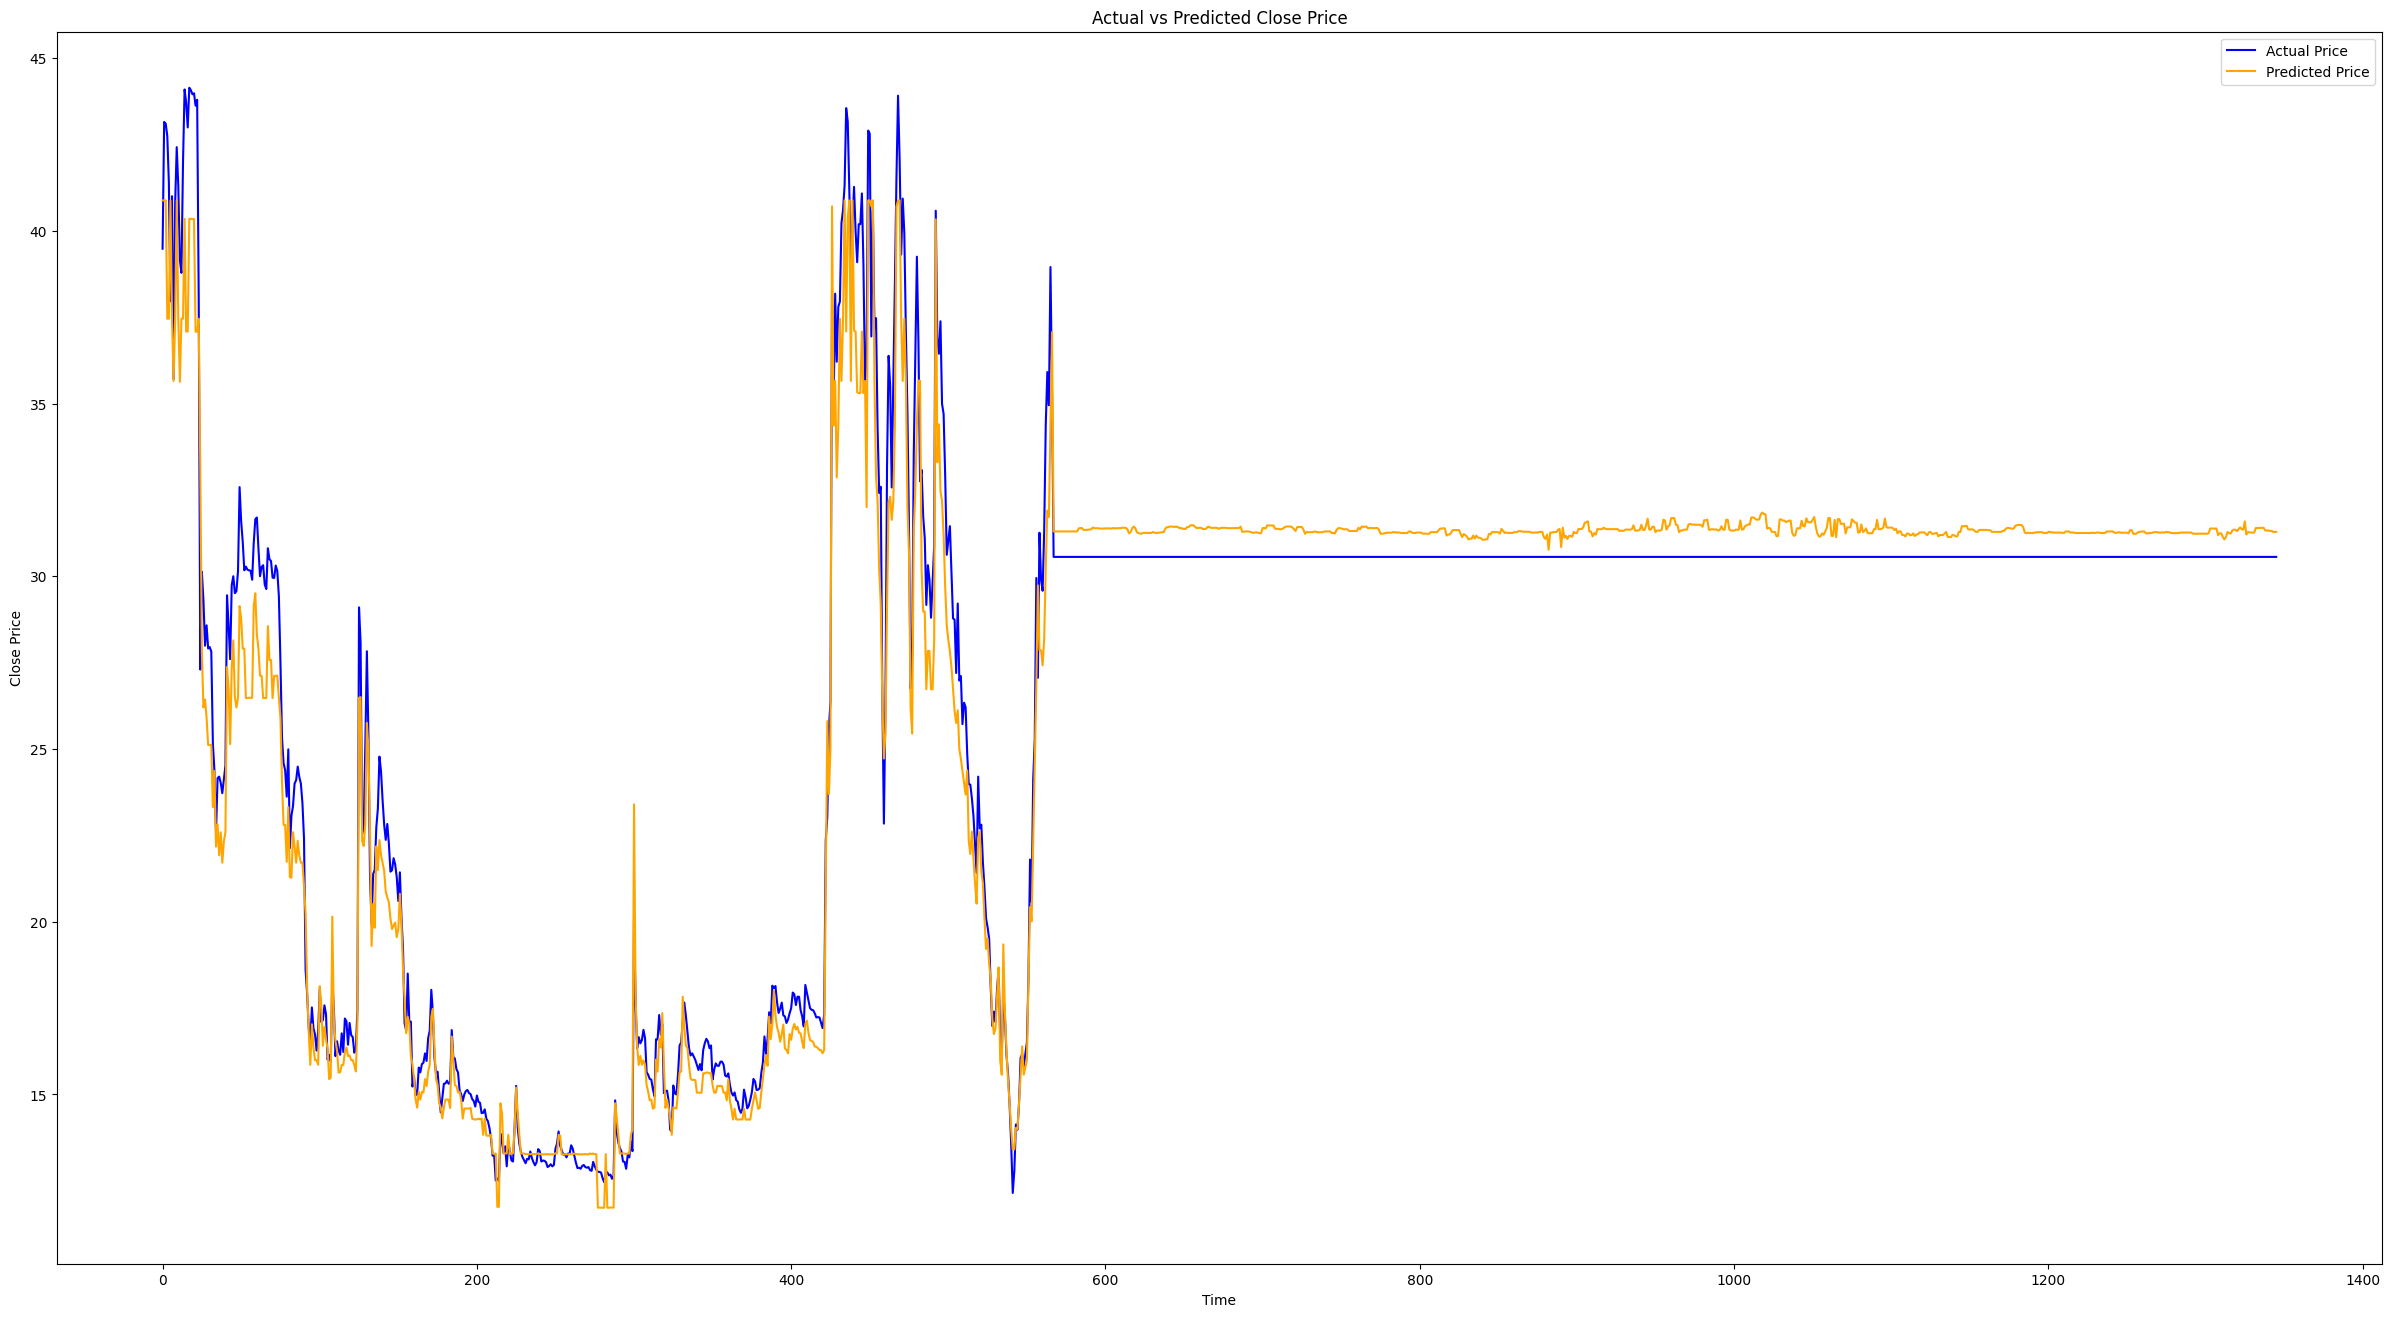

In [409]:
# Ensure y_pred and target are single-column DataFrames before reshaping
y_pred_reshaped = pd.DataFrame(y_pred, columns=["Close"]).values.reshape(-1, 1)
target_reshaped = pd.DataFrame(target_scaled, columns=["Close"]).values.reshape(-1, 1)

mse = mean_squared_error(target_reshaped, y_pred_reshaped)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Perform inverse transformation
y_pred_original = standard_scaler_close.inverse_transform(y_pred_reshaped)
target_original = standard_scaler_close.inverse_transform(target_reshaped)

# Plot the original vs. predicted values
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(target_original, y_pred_original)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')

plt.figure(figsize=(30, 16))
plt.plot(target_original, label="Actual Price", color="blue")
plt.plot(y_pred_original, label="Predicted Price", color="orange")
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()
